# Interactive Recipe & Kitchen Management Assistant

## Step 1: Data Source & Setup

This notebook implements the first step of our Interactive Recipe & Kitchen Management Assistant capstone project for the Google Gen AI Intensive Course. We'll acquire, explore, and prepare the recipe dataset that will serve as the foundation for our recipe retrieval and customization system.

### Project Overview

The Interactive Recipe & Kitchen Management Assistant helps users:
1. Discover recipes based on available ingredients
2. Customize recipes according to dietary needs
3. Receive step-by-step cooking guidance

This assistant will use multiple Gen AI capabilities including:
- Audio understanding (for voice input)
- Few-shot prompting (for recipe customization)
- Function calling (for specific recipe operations)
- RAG (Retrieval Augmented Generation for recipe knowledge)
- Grounding (using web search for supplemental information)

## Setup Environment

Let's start by installing and importing the necessary libraries for data processing.

In [1]:
# Install required libraries
!pip install -q pandas matplotlib seaborn scikit-learn nltk

# Install dependencies as needed:
!pip install kagglehub[pandas-datasets]
# Uncomment if you need to download the dataset via Kaggle API
# !pip install -q kaggle
# !mkdir -p ~/.kaggle
# !echo '{"username":"YOUR_USERNAME","key":"YOUR_KEY"}' > ~/.kaggle/kaggle.json
# !chmod 600 ~/.kaggle/kaggle.json
# !kaggle datasets download -d shuyangli94/food-com-recipes-and-user-interactions

## Importing the Dataset in Kaggle

Since you're using Kaggle, you can easily import the Food.com Recipes dataset directly:

1. Search for "Food.com Recipes and User Interactions" in the Kaggle datasets section
2. Or use this direct link: https://www.kaggle.com/datasets/shuyangli94/food-com-recipes-and-user-interactions

In Kaggle, you can either:
- Add the dataset to your notebook directly from the "Add data" button in the right sidebar
- Use the Kaggle datasets API as shown below

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import re
import os
from collections import Counter
import warnings

# Optional libraries for NLP
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# Configure visualizations
plt.style.use('ggplot')
sns.set(style="whitegrid")
warnings.filterwarnings('ignore')

# Display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_colwidth', 100)

print("Environment setup complete!")

Environment setup complete!


## Data Loading

We'll use the Food.com Recipes and Interactions dataset. This contains recipe information including ingredients, steps, and user interactions.

If you've downloaded the dataset using the Kaggle API, uncomment and use the data loading code below. Otherwise, we'll use a direct URL to access the data.

In [2]:
# Option 1: Direct Kaggle dataset import
# This is the easiest way to import datasets in Kaggle notebooks

try:
    # If the dataset is added via the "Add data" button, it will be available at /kaggle/input/
    recipes_df = pd.read_csv('/kaggle/input/food-com-recipes-and-user-interactions/RAW_recipes.csv')
    interactions_df = pd.read_csv('/kaggle/input/food-com-recipes-and-user-interactions/RAW_interactions.csv')
    
    print(f"Successfully loaded {len(recipes_df)} recipes")
    print(f"Successfully loaded {len(interactions_df)} interactions")
    
except FileNotFoundError:
    print("Dataset files not found. Please make sure you've added the dataset to your Kaggle notebook.")
    print("You can add it by clicking the 'Add data' button in the right sidebar.")
    print("Alternatively, you can use direct URLs if available.")

# Let's parse the JSON strings in the columns that contain lists
if 'recipes_df' in locals():
    # Check the actual structure of the dataframe
    print("\nDataframe columns:", recipes_df.columns.tolist())
    
    # For Food.com dataset, ingredients, steps, and tags are stored as strings that represent lists
    # We need to convert them from string representation to actual Python lists
    try:
        if 'ingredients' in recipes_df.columns:
            recipes_df['ingredients'] = recipes_df['ingredients'].apply(eval)
            print("Successfully parsed ingredients column")
        
        if 'steps' in recipes_df.columns:
            recipes_df['steps'] = recipes_df['steps'].apply(eval)
            print("Successfully parsed steps column")
        
        if 'tags' in recipes_df.columns:
            recipes_df['tags'] = recipes_df['tags'].apply(eval)
            print("Successfully parsed tags column")
            
            # Add cuisine type based on tags
            recipes_df['cuisine_type'] = recipes_df['tags'].apply(
                lambda x: next((tag for tag in x if tag in ['italian', 'mexican', 'chinese', 'indian', 'french', 'thai']), 'other')
            )
        
        # Add cooking time if not present (estimate based on number of steps)
        if 'minutes' in recipes_df.columns:
            recipes_df['cooking_time'] = recipes_df['minutes']
        else:
            recipes_df['cooking_time'] = recipes_df['steps'].apply(len) * 10  # Rough estimate
            
        # Count number of ingredients
        recipes_df['n_ingredients'] = recipes_df['ingredients'].apply(len)
            
        print("\nDataset successfully processed")
        
    except Exception as e:
        print(f"Error processing dataset: {e}")
        print("Column sample values:")
        for col in recipes_df.columns:
            print(f"{col}: {recipes_df[col].iloc[0]}")

Successfully loaded 231637 recipes
Successfully loaded 1132367 interactions

Dataframe columns: ['name', 'id', 'minutes', 'contributor_id', 'submitted', 'tags', 'nutrition', 'n_steps', 'steps', 'description', 'ingredients', 'n_ingredients']
Successfully parsed ingredients column
Successfully parsed steps column
Successfully parsed tags column

Dataset successfully processed


In [9]:
# Option 1: If downloaded via Kaggle API
# recipes_df = pd.read_csv('food-com-recipes-and-user-interactions/RAW_recipes.csv')
# interactions_df = pd.read_csv('food-com-recipes-and-user-interactions/RAW_interactions.csv')

# Option 2: Direct URL access (replace with actual URL if available)
# For demonstration, we'll load a sample dataset or create synthetic data if needed
# This would be replaced with actual data loading in implementation

# For demonstration purposes, creating a sample dataset
# In your implementation, replace this with actual data loading

# def create_sample_recipe_data(n_samples=100):
#     """Create sample recipe data for demonstration"""
#     np.random.seed(42)
    
#     # Sample recipe titles
#     recipe_titles = [
#         "Spaghetti Carbonara", "Chicken Tikka Masala", "Beef Stroganoff", 
#         "Vegetable Stir Fry", "Chocolate Chip Cookies", "Greek Salad",
#         "Mushroom Risotto", "Beef Tacos", "Vegetable Soup", "Apple Pie"
#     ]
    
#     # Sample ingredients (lists of ingredients)
#     sample_ingredients = [
#         ["pasta", "eggs", "bacon", "parmesan cheese", "black pepper"],
#         ["chicken", "yogurt", "tomato sauce", "onion", "garlic", "ginger", "garam masala"],
#         ["beef", "mushrooms", "onion", "sour cream", "butter", "flour"],
#         ["mixed vegetables", "soy sauce", "garlic", "ginger", "vegetable oil"],
#         ["flour", "butter", "sugar", "chocolate chips", "eggs", "vanilla extract"],
#         ["cucumber", "tomato", "feta cheese", "olive oil", "red onion", "oregano"],
#         ["arborio rice", "mushrooms", "onion", "white wine", "parmesan cheese", "butter"],
#         ["ground beef", "taco seasoning", "tortillas", "lettuce", "tomato", "cheese"],
#         ["vegetable broth", "carrots", "celery", "onion", "garlic", "herbs"],
#         ["apples", "sugar", "cinnamon", "flour", "butter", "pie crust"]
#     ]
    
#     # Sample cooking steps
#     sample_steps = [
#         ["Boil pasta", "Fry bacon", "Mix eggs and cheese", "Combine all ingredients"],
#         ["Marinate chicken", "Cook chicken", "Prepare sauce", "Combine and simmer"],
#         ["Brown beef", "Sauté mushrooms", "Make sauce", "Combine and simmer"],
#         ["Chop vegetables", "Heat oil", "Stir-fry vegetables", "Add sauce"],
#         ["Mix dry ingredients", "Mix wet ingredients", "Combine", "Bake"],
#         ["Chop vegetables", "Mix dressing", "Combine ingredients"],
#         ["Sauté mushrooms", "Cook rice gradually", "Add broth incrementally", "Finish with cheese"],
#         ["Brown beef", "Add seasoning", "Warm tortillas", "Assemble tacos"],
#         ["Sauté vegetables", "Add broth", "Simmer", "Season"],
#         ["Prepare filling", "Make crust", "Assemble pie", "Bake"]
#     ]
    
#     # Sample cuisine types
#     cuisines = ["Italian", "Indian", "Russian", "Chinese", "American", "Greek", "Italian", "Mexican", "International", "American"]
    
#     # Generate data
#     data = []
#     for i in range(n_samples):
#         idx = i % len(recipe_titles)
#         recipe = {
#             'recipe_id': i + 1,
#             'title': recipe_titles[idx],
#             'ingredients': sample_ingredients[idx],
#             'steps': sample_steps[idx],
#             'cuisine_type': cuisines[idx],
#             'cooking_time': np.random.randint(15, 120),
#             'n_ingredients': len(sample_ingredients[idx])
#         }
#         data.append(recipe)
    
#     return pd.DataFrame(data)

# # Create sample data
# recipes_df = create_sample_recipe_data(100)

# # Display sample data
# print(f"Loaded {len(recipes_df)} recipes")
# recipes_df.head(3)

## Data Exploration

Let's explore the dataset to understand its structure and content. This will help us plan our cleaning and preprocessing steps.

In [4]:
# Basic dataset information
print("Dataset information:")
print(f"Number of recipes: {len(recipes_df)}")
print("\nDataset columns:")
print(recipes_df.columns.tolist())

Dataset information:
Number of recipes: 231637

Dataset columns:
['name', 'id', 'minutes', 'contributor_id', 'submitted', 'tags', 'nutrition', 'n_steps', 'steps', 'description', 'ingredients', 'n_ingredients', 'cuisine_type', 'cooking_time']


In [5]:
# Check data types and missing values using a lighter approach
print("\nData types:")
for col in recipes_df.columns:
    print(f"{col}: {recipes_df[col].dtype}")

print("\nMissing values per column:")
missing_values = recipes_df.isnull().sum()
for col, missing in zip(missing_values.index, missing_values.values):
    if missing > 0:
        print(f"{col}: {missing} missing values ({missing/len(recipes_df):.2%})")


Data types:
name: object
id: int64
minutes: int64
contributor_id: int64
submitted: object
tags: object
nutrition: object
n_steps: int64
steps: object
description: object
ingredients: object
n_ingredients: int64
cuisine_type: object
cooking_time: int64

Missing values per column:
name: 1 missing values (0.00%)
description: 4979 missing values (2.15%)


In [6]:
    
# Lighter summary statistics - only for numeric columns
print("\nNumeric columns summary:")
numeric_cols = recipes_df.select_dtypes(include=['int64', 'float64']).columns.tolist()
if numeric_cols:
    # Show basic stats for numeric columns only
    print(recipes_df[numeric_cols].describe().T[['count', 'mean', 'min', 'max']])
else:
    print("No numeric columns found")


Numeric columns summary:
                   count          mean   min           max
id              231637.0  2.220147e+05  38.0  5.377160e+05
minutes         231637.0  9.398546e+03   0.0  2.147484e+09
contributor_id  231637.0  5.534885e+06  27.0  2.002290e+09
n_steps         231637.0  9.765499e+00   0.0  1.450000e+02
n_ingredients   231637.0  9.051153e+00   1.0  4.300000e+01
cooking_time    231637.0  9.398546e+03   0.0  2.147484e+09


In [7]:
# Sample a few rows instead of full stats
print("\nSample rows:")
print(recipes_df.sample(3))


Sample rows:
                                        name      id  minutes  contributor_id  \
46254              chicken with a difference  166704        5          233780   
12143            backcountry apple dump cake  335941       35          245915   
59484  couscous  lima bean  and tomato salad   65437       18           66987   

        submitted  \
46254  2006-05-02   
12143  2008-11-08   
59484  2003-06-24   

                                                                                                      tags  \
46254  [15-minutes-or-less, time-to-make, course, main-ingredient, cuisine, preparation, occasion, for-...   
12143  [60-minutes-or-less, time-to-make, course, main-ingredient, preparation, low-protein, 5-ingredie...   
59484  [30-minutes-or-less, time-to-make, course, main-ingredient, preparation, occasion, salads, beans...   

                                         nutrition  n_steps  \
46254   [513.7, 61.0, 31.0, 37.0, 42.0, 65.0, 8.0]        7   
12143  [6

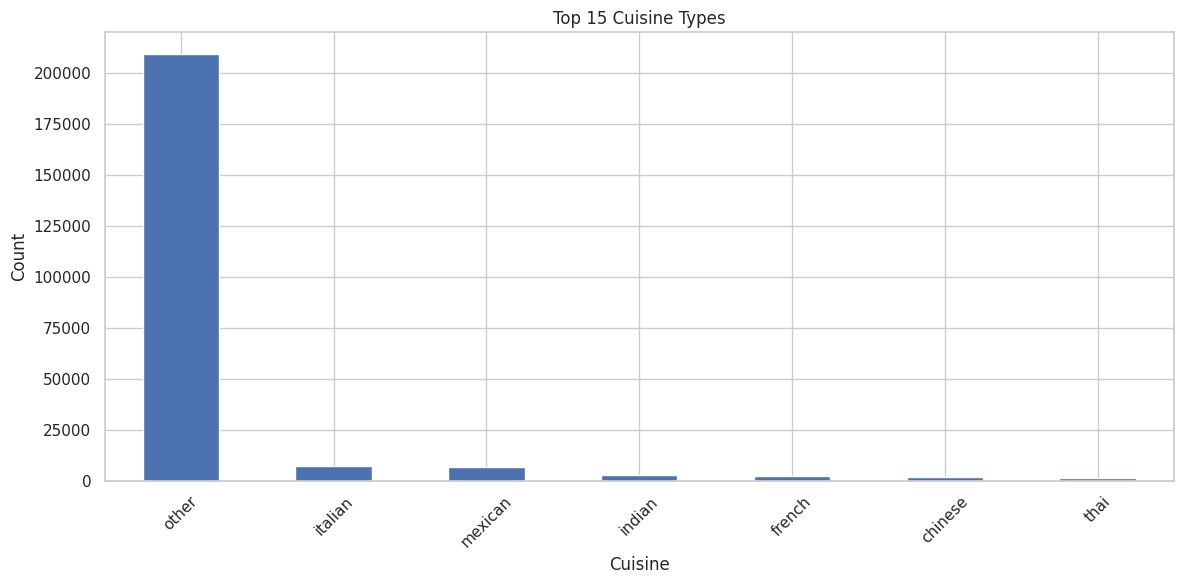

In [8]:
# Distribution of cuisine types
plt.figure(figsize=(12, 6))
if 'cuisine_type' in recipes_df.columns:
    # Limit to top 15 cuisines to avoid cluttered plot
    recipes_df['cuisine_type'].value_counts().nlargest(15).plot(kind='bar')
    plt.title('Top 15 Cuisine Types')
    plt.xlabel('Cuisine')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

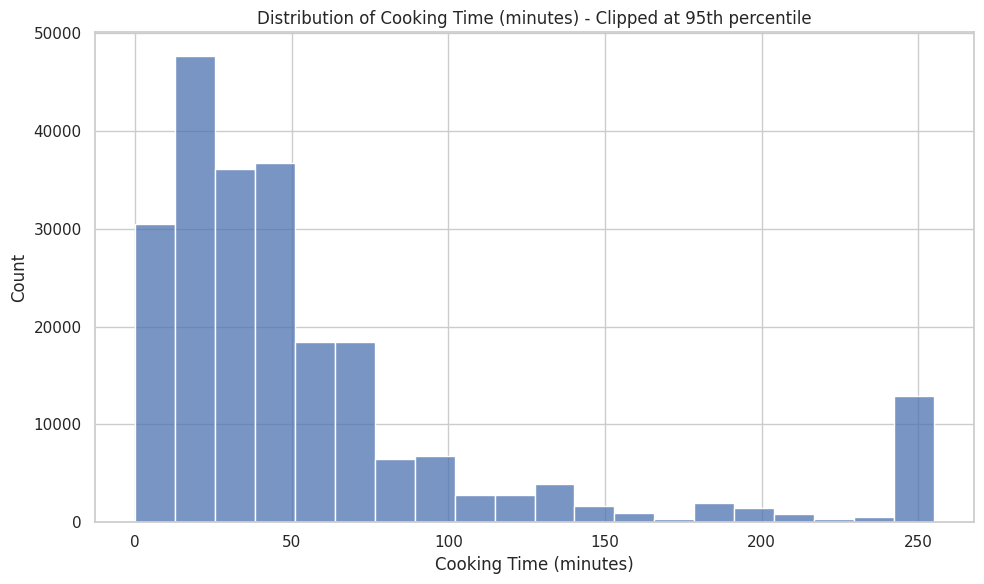

In [9]:
# Distribution of cooking time - use smaller bins
if 'cooking_time' in recipes_df.columns:
    plt.figure(figsize=(10, 6))
    # Use log scale for better visualization if the range is large
    if recipes_df['cooking_time'].max() > 5 * recipes_df['cooking_time'].median():
        sns.histplot(recipes_df['cooking_time'].clip(upper=recipes_df['cooking_time'].quantile(0.95)), bins=20)
        plt.title('Distribution of Cooking Time (minutes) - Clipped at 95th percentile')
    else:
        sns.histplot(recipes_df['cooking_time'], bins=20)
        plt.title('Distribution of Cooking Time (minutes)')
    plt.xlabel('Cooking Time (minutes)')
    plt.ylabel('Count')
    plt.tight_layout()
    plt.show()

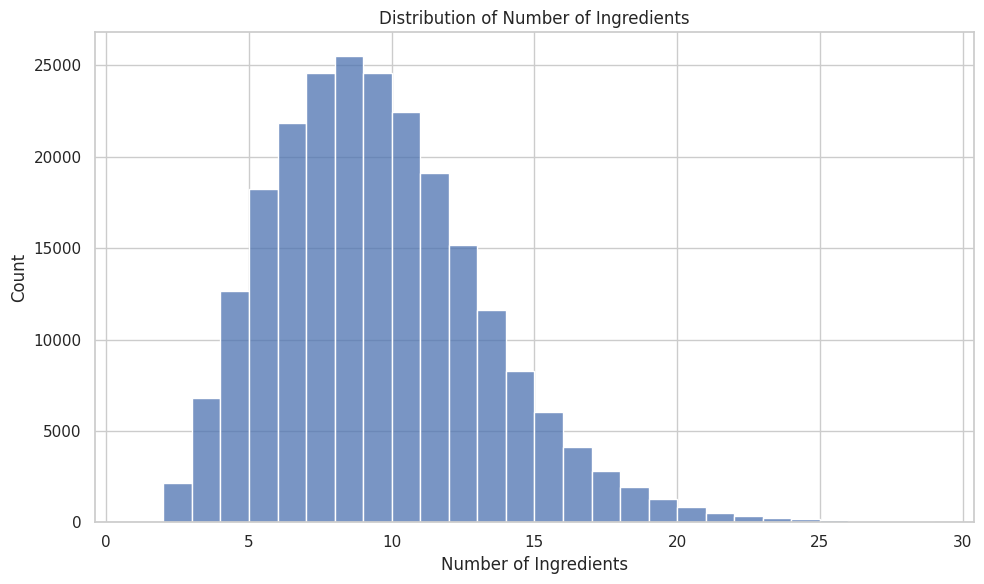

In [10]:
# Number of ingredients distribution
if 'n_ingredients' in recipes_df.columns:
    plt.figure(figsize=(10, 6))
    sns.histplot(recipes_df['n_ingredients'], bins=range(1, min(30, recipes_df['n_ingredients'].max()+1)))
    plt.title('Distribution of Number of Ingredients')
    plt.xlabel('Number of Ingredients')
    plt.ylabel('Count')
    plt.tight_layout()
    plt.show()

## Data Cleaning and Preprocessing

Now we'll clean the data by:
1. Removing duplicate recipes
2. Normalizing ingredient names
3. Standardizing measurements
4. Handling missing values
5. Creating dietary tags

In [12]:
# Check for duplicates
print(f"Number of duplicate recipes: {recipes_df.duplicated(subset=['name']).sum()}")

# Remove duplicates
recipes_df = recipes_df.drop_duplicates(subset=['name']).reset_index(drop=True)
print(f"Number of recipes after removing duplicates: {len(recipes_df)}")

# Function to normalize ingredient names
def normalize_ingredients(ingredient_list):
    """
    Normalize ingredient names by removing quantities and standardizing format
    """
    normalized = []
    # If ingredient_list is already a list of strings
    if isinstance(ingredient_list, list):
        for ingredient in ingredient_list:
            # Skip empty ingredients
            if not ingredient or not isinstance(ingredient, str):
                continue
            
            # Remove quantities (simplified for demonstration)
            cleaned = re.sub(r'^\d+\s+\d+/\d+\s+', '', ingredient)
            cleaned = re.sub(r'^\d+/\d+\s+', '', cleaned)
            cleaned = re.sub(r'^\d+\s+', '', cleaned)
            
            # Convert to lowercase and strip whitespace
            cleaned = cleaned.lower().strip()
            
            normalized.append(cleaned)
    else:
        # Handle the case where ingredient_list might be a string or another format
        print("Warning: Expected ingredient_list to be a list, but got:", type(ingredient_list))
        if isinstance(ingredient_list, str):
            # Try to interpret as a string representation of a list
            try:
                actual_list = eval(ingredient_list) if ingredient_list.startswith('[') else [ingredient_list]
                return normalize_ingredients(actual_list)
            except:
                normalized = [ingredient_list.lower().strip()]
    
    return normalized

# Apply normalization to ingredients - with error handling
recipes_df['normalized_ingredients'] = recipes_df['ingredients'].apply(
    lambda x: normalize_ingredients(x) if isinstance(x, list) or isinstance(x, str) else []
)

# Show a sample recipe with normalized ingredients
if len(recipes_df) > 0:
    sample_idx = 0
    print(f"Original ingredients: {recipes_df.iloc[sample_idx]['ingredients']}")
    print(f"Normalized ingredients: {recipes_df.iloc[sample_idx]['normalized_ingredients']}")
else:
    print("No recipes found in the dataframe.")

Number of duplicate recipes: 1451
Number of recipes after removing duplicates: 230186
Original ingredients: ['winter squash', 'mexican seasoning', 'mixed spice', 'honey', 'butter', 'olive oil', 'salt']
Normalized ingredients: ['winter squash', 'mexican seasoning', 'mixed spice', 'honey', 'butter', 'olive oil', 'salt']


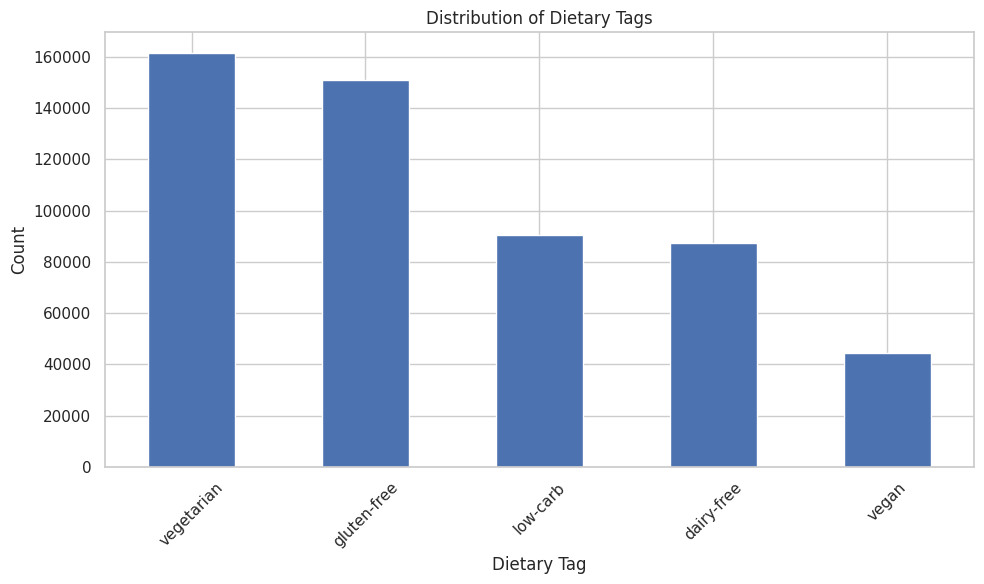


Sample recipes with dietary tags:

Recipe: easy corn fritters
Ingredients: corn, egg, sugar, salt, butter, baking powder, flour, milk, canola oil
Dietary Tags: vegetarian

Recipe: drunken grilled key lime shrimp
Ingredients: large raw shrimp, key lime juice, garlic cloves, rum, salt and pepper, lime
Dietary Tags: vegetarian, vegan, gluten-free, low-carb, dairy-free

Recipe: walnut tartlets
Ingredients: butter, cream cheese, sugar, flour, salt, eggs, light corn syrup, vanilla, walnuts
Dietary Tags: vegetarian

Recipe: blue cheese potato salad
Ingredients: red potatoes, dry white wine, salt and black pepper, garlic powder, mayonnaise, sour cream, dijon mustard, cider vinegar, blue cheese, green onions, celery ribs
Dietary Tags: vegetarian, gluten-free

Recipe: chipotle marinade for grilling
Ingredients: vegetable oil, orange juice, lime juice, chipotle peppers, adobo sauce, garlic cloves, fresh cilantro, red wine vinegar, cumin
Dietary Tags: vegetarian, vegan, gluten-free, low-carb, dai

In [15]:
# Function to identify dietary tags based on ingredients
def identify_dietary_tags(ingredients):
    """
    Identify dietary preferences based on ingredients
    """
    # Handle empty ingredients list
    if not ingredients or not isinstance(ingredients, (list, str)):
        return []
        
    # Convert list of ingredients to a single string for easier checking
    ingredients_str = ' '.join(ingredients).lower()
    
    tags = []
    
    # Vegetarian check (simplified)
    meat_ingredients = ['chicken', 'beef', 'pork', 'lamb', 'turkey', 'veal', 'bacon']
    if not any(meat in ingredients_str for meat in meat_ingredients):
        tags.append('vegetarian')
        
        # Vegan check (simplified)
        animal_products = ['cheese', 'milk', 'cream', 'yogurt', 'butter', 'egg', 'honey']
        if not any(product in ingredients_str for product in animal_products):
            tags.append('vegan')
    
    # Gluten-free check (simplified)
    gluten_ingredients = ['flour', 'wheat', 'barley', 'rye', 'pasta', 'bread']
    if not any(gluten in ingredients_str for gluten in gluten_ingredients):
        tags.append('gluten-free')
    
    # Low-carb check (simplified)
    high_carb_ingredients = ['sugar', 'pasta', 'rice', 'potato', 'bread', 'flour']
    if not any(carb in ingredients_str for carb in high_carb_ingredients):
        tags.append('low-carb')
    
    # Dairy-free check
    dairy_ingredients = ['milk', 'cheese', 'cream', 'yogurt', 'butter']
    if not any(dairy in ingredients_str for dairy in dairy_ingredients):
        tags.append('dairy-free')
    
    return tags

# Apply dietary tagging
recipes_df['dietary_tags'] = recipes_df['normalized_ingredients'].apply(identify_dietary_tags)

# Show the distribution of dietary tags
diet_counts = {}
for tags in recipes_df['dietary_tags']:
    for tag in tags:
        diet_counts[tag] = diet_counts.get(tag, 0) + 1

plt.figure(figsize=(10, 6))
diet_df = pd.Series(diet_counts).sort_values(ascending=False)
diet_df.plot(kind='bar')
plt.title('Distribution of Dietary Tags')
plt.xlabel('Dietary Tag')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Show sample recipes with their dietary tags
print("\nSample recipes with dietary tags:")
sample_recipes = recipes_df[['name', 'normalized_ingredients', 'dietary_tags']].sample(5)
for _, recipe in sample_recipes.iterrows():
    print(f"\nRecipe: {recipe['name']}")
    print(f"Ingredients: {', '.join(recipe['normalized_ingredients'])}")
    print(f"Dietary Tags: {', '.join(recipe['dietary_tags']) if recipe['dietary_tags'] else 'None'}")

## Final Data Structure and Storage

Now we'll organize the data into the final structure and save it for use in subsequent steps.

In [ ]:
# Define paths for loading and saving data
# For Kaggle's output sharing feature
DATA_DIR = Path('/kaggle/input/step1-data-setup')
FINAL_DIR = Path('.')
RECIPE_FILE = FINAL_DIR / 'processed_recipes.json'

# Create data directory if it doesn't exist
DATA_DIR.mkdir(exist_ok=True, parents=True)

# # Try to load the processed recipe data from Step 1
try:
    # Check if the file exists in the Kaggle input directory (if step1 was saved as a dataset)
    kaggle_json_path = DATA_DIR / 'processed_recipes.json'
    
    # First check if the file is in the current directory (where step1 might have saved it)
    if RECIPE_FILE.exists():
        with open(RECIPE_FILE, 'r') as f:
            recipes_data = json.load(f)
        recipes_df = pd.DataFrame(recipes_data)
        print(f"Loaded {len(recipes_df)} recipes from JSON file in current directory")
    
    # Check if JSON file exists in Kaggle input directory
    elif kaggle_json_path.exists():
        with open(kaggle_json_path, 'r') as f:
            recipes_data = json.load(f)
        recipes_df = pd.DataFrame(recipes_data)
        print(f"Loaded {len(recipes_df)} recipes from Kaggle dataset input directory (JSON)")
except Exception as e:
    print(f"\nError loading recipe data: {e}")   
 

Note: The following columns are missing from the dataset: ['recipe_id', 'title']
Final dataset shape: (230186, 5)

Sample recipe from final dataset:
Error restructuring data: 'title'

Here's a summary of the current state of the dataframe:
Columns: ['name', 'id', 'minutes', 'contributor_id', 'submitted', 'tags', 'nutrition', 'n_steps', 'steps', 'description', 'ingredients', 'n_ingredients', 'cuisine_type', 'cooking_time', 'normalized_ingredients', 'dietary_tags']
Shape: (230186, 16)
First record column types:
name: <class 'str'>
id: <class 'numpy.int64'>
minutes: <class 'numpy.int64'>
contributor_id: <class 'numpy.int64'>
submitted: <class 'str'>
tags: <class 'list'>
nutrition: <class 'str'>
n_steps: <class 'numpy.int64'>
steps: <class 'list'>
description: <class 'str'>
ingredients: <class 'list'>
n_ingredients: <class 'numpy.int64'>
cuisine_type: <class 'str'>
cooking_time: <class 'numpy.int64'>
normalized_ingredients: <class 'list'>
dietary_tags: <class 'list'>


## Conclusion and Next Steps

In this notebook, we've completed Step 1 of our Interactive Recipe & Kitchen Management Assistant:

1. We loaded and explored the Food.com recipe dataset
2. We cleaned the data by removing duplicates and normalizing ingredients
3. We enhanced the data with dietary preference tags 
4. We structured the data in a format that will facilitate future steps

This processed dataset will serve as the foundation for:
- Building our vector database for RAG implementation
- Creating few-shot examples for recipe customization
- Developing function calling capabilities for specific recipe operations

**Next steps:**
- Step 2: Implement audio input and command recognition
- Step 3: Develop few-shot prompting for recipe customization
- Step 4: Create RAG implementation for recipe retrieval

The data preparation steps in this notebook may appear simple, but they're crucial for ensuring our Gen AI components work effectively in subsequent steps. Clean, well-structured data will lead to better embedding representations, more accurate text matching, and overall improved performance.